<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/effective_radius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.wcs import WCS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


Тут я открывал заголовок фитс-фаила.

In [122]:
#hdul = fits.open("maps/hlsp_frontier_hst_acs-30mas_macs1149_f606w_v1.0-epoch2_drz.fits")  # open a FITS file
#hdr = hdul[0].header  # the primary HDU header
#hdr

Тут я сделал это немного по-другому:

In [124]:
map = fits.open("maps/hlsp_frontier_hst_acs-30mas_macs1149_f606w_v1.0-epoch2_drz.fits")

image = map[0].data
header = map[0].header

w = WCS(header)
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 177.3946025  22.40132035  
CRPIX : 5400.0  5400.0  
CD1_1 CD1_2  : -8.3333333333333e-06  0.0  
CD2_1 CD2_2  : 0.0  8.33333333333334e-06  
NAXIS : 10800  10800

Координаты галактики-линзы:

In [98]:
RA = 177.397782
DEC = 22.395448

Попробуем перевести их в пиксели на объявленной выше карте:

In [125]:
px, py = w.wcs_world2pix(RA, DEC, 0)

# Find the nearest integer pixel
px = np.round(px).astype(int)
py = np.round(py).astype(int)

print(px, py)

5046 4694


Посмотрим, что находится в этой области:

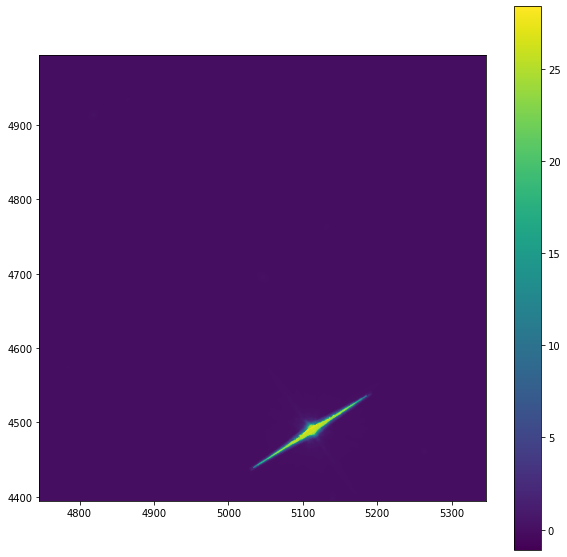

In [129]:
image_data = fits.getdata("maps/hlsp_frontier_hst_acs-30mas_macs1149_f606w_v1.0-epoch2_drz.fits")

plt.figure(figsize=(10,10))
plt.imshow(image_data, origin='lower')
plt.xlim(px-300, px+300)
plt.ylim(py-300, py+300)
plt.colorbar()
plt.show()

Не стал разбираться, в чём дело, и просто вручную нашёл координаты центра галактики (позже надо понять, что не так):

In [131]:
xc = 5113
yc = 4490

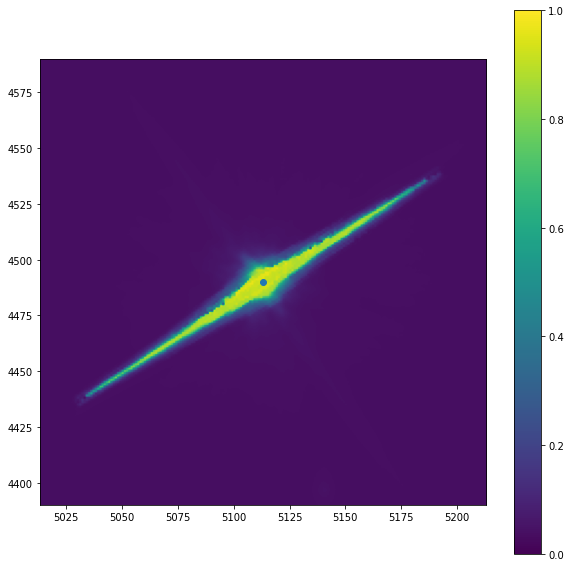

In [132]:
plt.figure(figsize=(10, 10))
plt.imshow(image_data, origin='lower')
plt.xlim(xc-100, xc+100)
plt.ylim(yc-100, yc+100)
plt.scatter(xc, yc)
plt.colorbar()
plt.show()

Взял из другой своей программы функции, вырезающие кружок из карты:

In [133]:
from matplotlib.patches import Rectangle

def createMyMask(rad_pix):
    
    w = 2*rad_pix
    h = 2*rad_pix
    
    center = [rad_pix, rad_pix]
    
    dist_from_center = np.zeros((w, h))
    z = dist_from_center*0    
      
    delta=1 
    x = np.arange(0, w, delta)
    y = np.arange(0, h, delta)

    Y, X = np.meshgrid(x,y)

    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    for i in range(0, w):
        for j in range(0, h):
            if dist_from_center[i][j] < rad_pix:
                z[i][j] = 1
            else:
                z[i][j] = 0
    
    return z#/np.sum(z)

#Функция, которая вырезает кружок из карты.

def cut_circle(image, center, rad_pix, graphics):
    
    kusok = np.zeros((2*rad_pix, 2*rad_pix))
    
    for i in range(center[1]-rad_pix, center[1]+rad_pix):
        for j in range(center[0]-rad_pix, center[0]+rad_pix):
             kusok[i - (center[1]-rad_pix)][j - (center[0]-rad_pix)] = image[i][j]
    
    circle_ones = createMyMask(rad_pix)
    mult = np.multiply(circle_ones, kusok)
    
    if graphics:
        
        plt.imshow(image, origin='lower')
        plt.colorbar()
        plt.gca().add_patch( Rectangle( (center[0]-rad_pix, center[1]-rad_pix), 2*rad_pix, 2*rad_pix, fill=None))
        plt.show()

        plt.imshow(kusok, origin='lower')
        plt.colorbar()
        plt.show()

        plt.imshow(mult, origin='lower')
        plt.colorbar()
        plt.show()
    
    return mult

Идея следующая: будем увеличивать радиус смотреть на суммарную светимость внутри него и строить зависимость её от радиуса:

Effective radius: 23 pixels


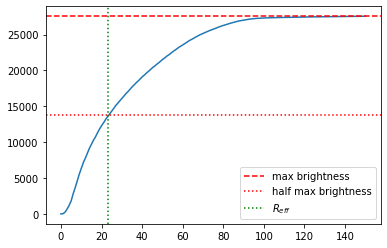

In [162]:
sum_br=[]
max_rad = 150
radii = np.linspace(0, max_rad, max_rad)

for radius in range(0, max_rad):
 sum_br.append( cut_circle(image, (xc,yc), radius, False).sum() )

plt.plot(radii, sum_br)
plt.axhline(int(np.max(sum_br)), color='r', linestyle = '--', label='max brightness')
plt.axhline(int(np.max(sum_br)/2), color='r', linestyle = ':', label='half max brightness')

r_eff = radii[ np.argmin(np.abs(sum_br - np.max(sum_br)/2)) ]
plt.axvline(r_eff, color='g', linestyle = ':', label='$R_{eff}$')
print('Effective radius:', int(r_eff), 'pixels')

plt.legend()
plt.show()

Понятно, что это довольно условно, ведь галактика не сферически симметричная. Но в первом приближении оценка неплохая (на мой взгляд). Из header'а фитс-файла можно найти, что разрешение карты 0,03 угловых секунды на пиксель. Найдём эффективный радиус единицах длины:

In [168]:
scale = 0.03

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

zl=0.541

Dl = cosmo.angular_diameter_distance(zl)

Dl*(r_eff*scale/3600*np.pi/180)

<Quantity 0.00441706 Mpc>

То есть эффективный радиус порядка 4,4 кпк. 

При этом по предыдущим оценкам получалось 4,93 кпк (https://arxiv.org/abs/1405.0038 и начало [вот этого](https://colab.research.google.com/drive/1GIxBW8ao4V6Iink2jegSIzApxlPAd2Ip) ноутбука).
